In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Läsa in filen och omvandla alla transaktioner till heltal
df = pd.read_excel('Transaktioner_687284538_2025-01-25_2025.xlsx')
df['Insättning/Uttag'] = df['Insättning/Uttag'].astype('int') 
df = df.sort_values('Reskontradag') # sortera all data i stigande orning på datum
df = df.rename(columns={'Reskontradag':'Datum', 'Insättning/Uttag':'Belopp'}) # döpa om column-namn till nått enklare
df = df[(df['Datum']>'2024-01-01') & (df['Datum']<'2025-01-01')].copy()

In [3]:
# ta bort columner som bara har 1 typ av värde
cols_to_drop = list()
for c in df.columns:
    if len(df[c].unique())==1:
        print(c)
        cols_to_drop.append(c)
df.drop(cols_to_drop, inplace=True, axis=1) 

Kontohavare
Kontonr
IBAN
BIC
Kontoform
Valuta
Kontoförande kontor
Datum intervall
Referens Swish
Avsändar-id Swish


In [4]:
# ta bort alla transaktioner som är exakt 500:- för att få bort medlemsavgifter
df = df[df['Belopp'] !=500].copy()

In [5]:
# titta lite på all data
df.head(10)

,Datum,Valutadag,Referens,Belopp
559,2024-01-06,2024-01-08,"BLOM,MARIA",50
558,2024-01-06,2024-01-08,Stephen Brian,50
557,2024-01-06,2024-01-08,ELINA BIRKEHAG,50
556,2024-01-06,2024-01-08,KENT LARSSON,10
554,2024-01-07,2024-01-08,Johan Falk,50
550,2024-01-07,2024-01-08,TORBJÖRN OLSSO,50
542,2024-01-13,2024-01-15,Susana Municio,50
541,2024-01-13,2024-01-15,"HAGBERG, LINUS",50
538,2024-01-14,2024-01-15,Hennawy Elhenn,100
537,2024-01-14,2024-01-15,Patrik Bååth,50


# Totala intäcker för 2024 från allmänheten 
inkl uthyrning av bastun som räknas som 15 personer

In [6]:
df['Belopp'].sum()

36898

# Omvandla från betalsystemet
Betalsystemet tar en avgift vilket gör att en bokning inte går att dela jämnt med 100:-
Formeln nedan rundar alla tal uppåt till närmsta 100-tal för att därefter lättare kunna göra omvandlingen till antal besökare.

In [7]:
# markera vilka poster som är hanterade av betalsystemet
df['betalsystem'] = df['Referens'].apply(lambda x: 'STRIPE' in x)

In [8]:
# kila på betalningar från betalsystemet
df[df['betalsystem']].head(10)

,Datum,Valutadag,Referens,Belopp,betalsystem
456,2024-03-25,2024-03-26,STRIPE K8F3,291,True
446,2024-03-28,2024-04-02,STRIPE N7Y6,93,True
436,2024-04-02,2024-04-03,STRIPE Q6W7,93,True
435,2024-04-02,2024-04-03,STRIPE H3P1,190,True
431,2024-04-03,2024-04-04,STRIPE G6S0,93,True
430,2024-04-04,2024-04-05,STRIPE H0R3,287,True
415,2024-04-16,2024-04-17,STRIPE T0X1,93,True
413,2024-04-17,2024-04-18,STRIPE B5Z0,291,True
412,2024-04-18,2024-04-19,STRIPE Z6Y4,195,True
403,2024-04-22,2024-04-23,STRIPE P2T6,190,True


In [9]:
def stripe_to_nearest_100(value):
    return int(((value/100)+0.5))*100

In [10]:
# kolla att funktionen gör rätt
stripe_to_nearest_100(771), stripe_to_nearest_100(96), stripe_to_nearest_100(195)

(800, 100, 200)

In [11]:
df.dtypes

Datum          datetime64[ns]
Valutadag      datetime64[ns]
Referens               object
Belopp                  int64
betalsystem              bool
dtype: object

In [12]:
# konvertera alla transaktioner från betalsystemet till jämna siffror för att lättare beräkna hur många besökare vi har
# Notera att summan av transaktioner inte längre kommer stämma efter denna modifikation
df.loc[df['betalsystem'], 'Belopp'] = df.loc[df['betalsystem'], 'Belopp'].apply(stripe_to_nearest_100)
df[df['betalsystem']].head(10)

,Datum,Valutadag,Referens,Belopp,betalsystem
456,2024-03-25,2024-03-26,STRIPE K8F3,300,True
446,2024-03-28,2024-04-02,STRIPE N7Y6,100,True
436,2024-04-02,2024-04-03,STRIPE Q6W7,100,True
435,2024-04-02,2024-04-03,STRIPE H3P1,200,True
431,2024-04-03,2024-04-04,STRIPE G6S0,100,True
430,2024-04-04,2024-04-05,STRIPE H0R3,300,True
415,2024-04-16,2024-04-17,STRIPE T0X1,100,True
413,2024-04-17,2024-04-18,STRIPE B5Z0,300,True
412,2024-04-18,2024-04-19,STRIPE Z6Y4,200,True
403,2024-04-22,2024-04-23,STRIPE P2T6,200,True


In [13]:
df['Belopp'].unique()

array([  50,   10,  100,   80,  300,  200,  400,  500, 1000,  800,  600,
        900, 1500])

In [16]:
df['Belopp'] = df['Belopp'].replace([10, 80], [50,100])

In [19]:
# Innan 1 maj kostade det 50kr/besök, omvandla swish betalningar till antal besökare
# 100kr blir 2 deltagare, 200kr blir 4 deltagare etc.
df.loc[df['Datum']<'2024-05-01', 'antal'] = df.loc[df['Datum']<'2024-05-01', 'Belopp']/50

In [20]:
# Efter 1 maj kostade det 100kr/besök, omvandla till antal besökarea
# Alla transaktioner som är 50kr kommer omvandlas till 100 kr.
# 100 kr blir härmed samma som 1 deltagare, 200kr blir 2 deltagare osv
df.loc[(df['Datum']>='2024-05-01') & (df['Belopp']==50), 'Belopp'] = 100
df.loc[df['Datum']>='2024-05-01', 'antal'] = df.loc[df['Datum']>='2024-05-01', 'Belopp']/100

In [21]:
data = df.set_index('Datum').groupby(pd.Grouper(freq='M'))['antal'].sum()
data

Datum
2024-01-31    13.0
2024-02-29     9.0
2024-03-31    33.0
2024-04-30    70.0
2024-05-31    28.0
2024-06-30    10.0
2024-07-31    19.0
2024-08-31    20.0
2024-09-30    62.0
2024-10-31    33.0
2024-11-30    89.0
2024-12-31    59.0
Freq: M, Name: antal, dtype: float64

# Totala antalet besökare:

In [25]:
months = 'jan feb mar apr maj jun jul aug sep okt nov dec'.split(' ')

<BarContainer object of 12 artists>

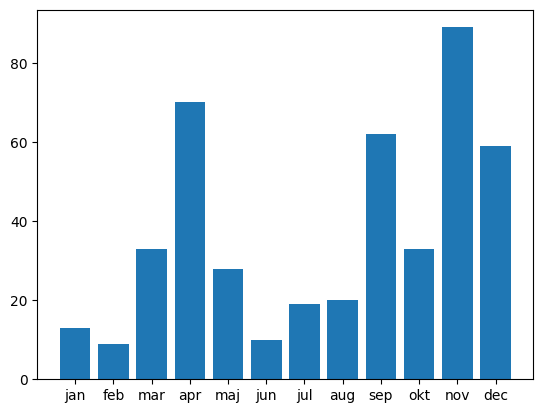

In [26]:
plt.bar(months, height=data.values)

# Antal besökare
Totala antalet besökare under 2024.

In [27]:
df['antal'].sum()

445.0

In [28]:
445-187

258